**Projet de réseau de neurones**
Sujet: Entrainement d'un réseau de neurones pour qu'il reconnaisse des commandes vocales

Lien du dataset:
http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip

Commandes vocales possibles:
- down
- go
- left
- no
- right
- stop
- up
- yes

Pour entrainer notre modèle, nous transformons chacun des extraits audio d'une taille fixe en spectrogramme et on le traite comme une image.

Pour le tester, on enregistre un extrait et on le découpe en extraits audios d'une taille fixe, puis on le teste.

Exemple de data sur laquelle on s'entraine (ex: oui et non en anglais):

Librairies

In [260]:
import os

import torch

# pour charger le dataset
from torch.utils.data import Dataset

# pour les transformations sur les extraits audio
import torchaudio 

# Téléchargement et extraction du dossier contenant les extraits audio
import urllib
import zipfile

# Affichage des extraits audio
import IPython 
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import math

# création d'un data loader
from torch.utils.data import DataLoader

# construction du réseau de neurones
from torch import nn

0 - Téléchargement du dataset

In [261]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'

# Création d'un dossier pour le dataset
lib_path = os.path.abspath("voice_control_nn.py")
path_len = len(current_path)
len_to_delete = len("notebook/voice_control_nn.py")
lib_path = current_path[:path_len-len_to_delete]
lib_path = os.path.join(current_path, "biblio")

# Le dataset ne sera téléchargé que si il n'a toujours pas
# encore été téléchargé
if (not os.path.exists(lib_path)):
    os.mkdir(lib_path)

    extract_dir = lib_path

    zip_path, _ = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(extract_dir)
    
### Le téléchargement peut prendre un certain temps

Voici quelques extraits téléchargés:
- yes

In [262]:
IPython.display.display(IPython.display.Audio("../biblio/mini_speech_commands/yes/0ab3b47d_nohash_0.wav"))

- no

In [263]:
IPython.display.display(IPython.display.Audio("../biblio/mini_speech_commands/no/0ab3b47d_nohash_0.wav"))

Classe du dataset. Cette classe contient les fonctions pour:
- Charger les extraits audios
- Uniformiser la sample rate ("résolution" du son) à une valeur cible
- Uniformiser les extraits en terme de temps
- Transformer un signal audio en Mel Spectrogramme

In [264]:

# classe Dataset
class VoiceCommandsDataset(Dataset):
    
    # fonction d'initialisation du dataset
    def __init__(self, 
                 PATH, 
                 COMMANDS, 
                 transformation, 
                 target_SR,
                 num_samples):
        
    
        # list des noms et chemins de fichier
        self.name_path = []
        # list des dir auquel appartient le fichier de même indexe
        self.label = []
        # pour chaque dossier associé à une commande
        for dir_name in COMMANDS:
            # pour chaque fichier dans le dossier de la commande
            for filename in os.listdir(os.path.join(PATH, dir_name)):
                self.name_path.append(os.path.join(PATH, dir_name, filename))
                self.label.append(dir_name)
                
        # transformation qui sera appliquée pour les extraits audios
        # pour les convertirs en mel_spectrogrammes
        self.transformation = transformation
        # Sample Rate pour laquelle on va convertir les extraits
        self.target_SR = target_SR
        #
        self.num_samples = num_samples
                
    
    # retourne le signal d'un extrait audio en le traitant pour
    # qu'il soit utilisable dans le réseau de neurone
    def __getitem__(self, index):
        sample_path = self.name_path[index]
        label = self.label[index]
        
        # extraction du signal analogique du .wav 
        # signal -> (num_channels, samples)
        signal, sample_rate = torchaudio.load(sample_path)
        
        ### PROCESSING
        
        # transforme le signal à la sample rate qu'on recherche
        if sample_rate != self.target_SR:
            signal = self._resample(signal, sample_rate)
        
        # transforme le signal en mono si il n'est pas en mono
        if signal.shape[0] > 1:
            signal = self._X_to_mono(signal)
            
        # traitement de la longeur de l'extrait audio
        if signal.shape[1] > self.num_samples:
            signal = self._cut(signal)
        elif signal.shape[1] < self.num_samples:
            signal = self._padd(signal)
        
        # transformation du signal en un mel_spectrogramme
        signal = self.transformation(signal)
        
        return signal, label
    
    # On coupe la fin du signal pour conformer l'extrait à la taille
    # recherchée
    def _cut(self, signal):
        signal = signal[:, :self.num_samples]
        return signal
    
    # On ajoute des zéros à droite de la structure (fin du son)
    # pour conformer l'extrait à la taille recherchée
    def _padd(self, signal):
        nb_missing_samples = self.num_samples - signal.shape[1]
        padding = (0, nb_missing_samples)
        signal = torch.nn.functional.pad(signal, padding)
        
    
    # converti un signal à la sr cible    
    def _resample(self, signal, sr):
        resampler = torchaudio.transforms.Resample(sr, self.target_SR)
        signal = resampler(signal)
        return signal
        
    
    # converti un son à plusieurs canaux à un son en mono
    def _X_to_mono(self, signal, sr):
        signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
        

Variables

In [312]:
# Variables
PATH = '../biblio/mini_speech_commands'
# modifier le contenus de COMMANDS pour changer les items du set
# (pas certaine de la stabilité)
COMMANDS = ['yes', 'no']
#COMMANDS = ['yes', 'no', 'go', 'stop']
# ###
SAMPLE_RATE = 16000 # ### à voir quel est la meilleur SR/ajouter explication
#
NUM_SAMPLES = 16000

Paramètrage du mel spectrogramme (Spectrogramme mélodique)

In [313]:
# memo
# Signal audio -> transformations de fourrier -> spectrogramme -> mel spectrogramme

# spectrogramme: convertis amplitude to db car plus pertinent à 
# la perception humaine

# On ne peut pas avoir une perception des changements de fréquence 
# comparable à celle des humains dans le son, dans les spectrogrammes 
# ordinaires
# Donc on utilise un Mel spectrogramme
# échelle de Mel: échelle logarithmique de la fréquence, qui permet 
# d'ajuster la fréquence à celle perçue par un humain
# Hz -> Mel
# Source: https://pytorch.org/audio/stable/transforms.html
# https://pytorch.org/audio/stable/generated/torchaudio.transforms.MelSpectrogram.html#torchaudio.transforms.MelSpectrogram
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024, # tailel d'une frame ### a chercher plus d'info 
    hop_length = 512, # moitié de la taille d'une frame ###
    n_mels = 64 # nb de filtres de mel fonctionne un peu comme la learning 
                # rate vaut habituellement entre ~ 40 et 128
)

Récupération du dataset

In [314]:
vcd = VoiceCommandsDataset(PATH, 
                           COMMANDS, 
                           mel_spectrogram, 
                           SAMPLE_RATE,
                           NUM_SAMPLES)

Testing

In [317]:
print(f"there are {len(vcd.name_path)} samples in the dataset.")
# le nombre d'items obtenus est correct (1000 par commande)

signal, label = vcd.__getitem__(0)
print(signal.size())

signal, label = vcd[56]
print(signal.size())

signal, label = vcd[256]
print(signal.size())

signal, label = vcd[999]
print(signal.size())

there are 4000 samples in the dataset.
torch.Size([1, 64, 32])
torch.Size([1, 64, 32])
torch.Size([1, 64, 32])
torch.Size([1, 64, 32])


Affichage des Signaux analogues vs Spectrogrammes pour 'Yes' et 'No':
- Signal analogue:
    - Yes

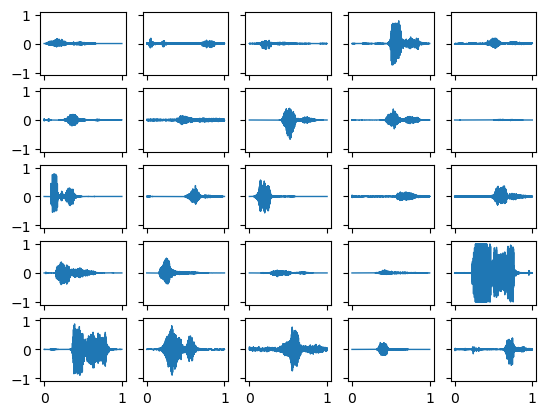

In [318]:
# affichage signal analogue
dimension = 5

# type_s: 0 pour analog, 1 pour spectrogramme 
def plot_nice_pics_of_sound(dataset, dim, command, type_s):
    count_ready_to_plot = 0
    i = 0
    fig, axes = plt.subplots(nrows=dim, ncols=dim, sharex=True, sharey=True, squeeze=False)
    while(count_ready_to_plot != dim*dim):
        l = count_ready_to_plot % dim # ligne
        c = math.floor(count_ready_to_plot/dim) # colonne
        
        signal, sample_rate = torchaudio.load(dataset.name_path[i])
                
        # if it's analog signal
        if (type_s == 0):
            if (command == dataset.label[i]) :   
                
                nb_chan, nb_frames = signal.shape
                time_axis = torch.arange(0, nb_frames) / SAMPLE_RATE
                axes[l][c].plot(time_axis, signal[0], linewidth=1)
                
                count_ready_to_plot+=1
        
        # si c'est un spectrogramme
        elif (type_s == 1):
            if (command == dataset.label[i]):
                signal = signal.flatten()
                Mel = librosa.feature.melspectrogram(y=signal.numpy(), sr=sample_rate)
                M_db = librosa.power_to_db(Mel, ref=np.max)
                img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=axes[l][c])
                #fig.colorbar(img, ax=axes[l][c], format="%+2.f dB")
                
                count_ready_to_plot+=1
                
        else:
            break
        
        i+=1
    plt.show()
    
plot_nice_pics_of_sound(vcd, dimension, 'yes', 0)

    - No

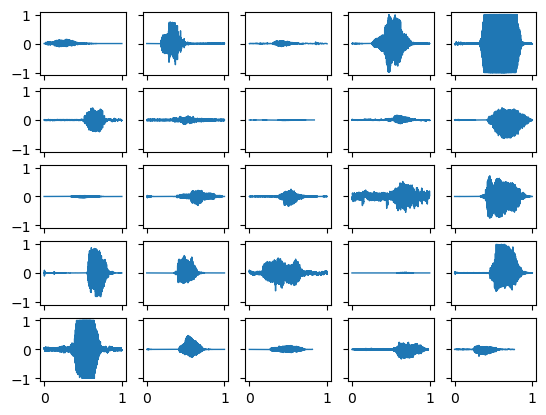

In [319]:
plot_nice_pics_of_sound(vcd, dimension, 'no', 0)

- Spectrogramme
    - Yes

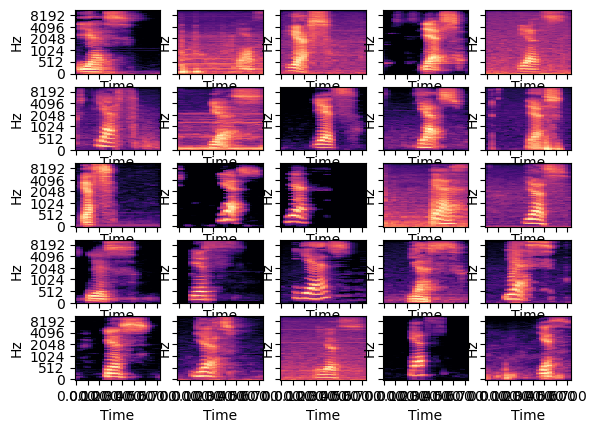

In [320]:
plot_nice_pics_of_sound(vcd, dimension, 'yes', 1)

        - no

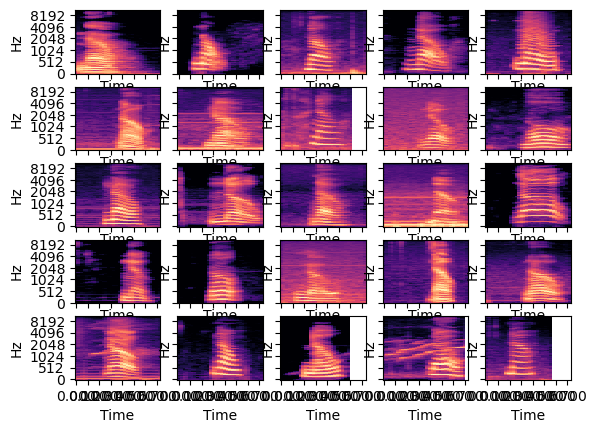

In [321]:
plot_nice_pics_of_sound(vcd, dimension, 'no', 1)

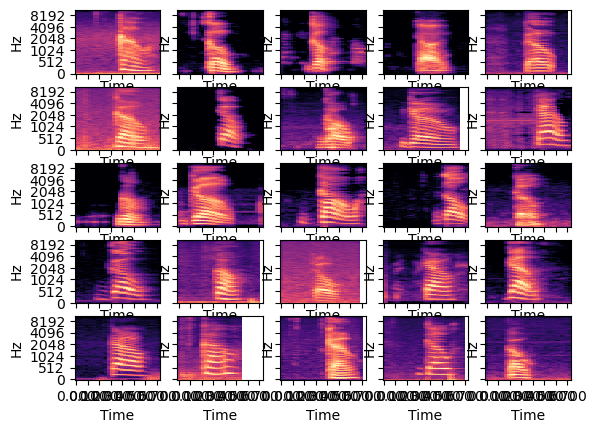

In [322]:
#plot_nice_pics_of_sound(vcd, dimension, 'go', 1)

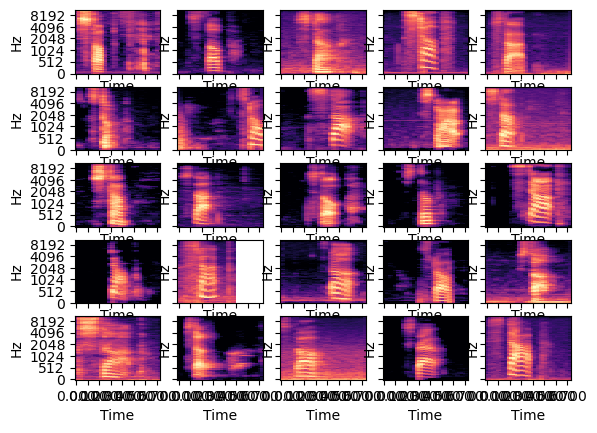

In [323]:
#plot_nice_pics_of_sound(vcd, dimension, 'stop', 1)

In [ ]:
# Pour obtenir 
# signal.flatten() ou signal.numpy().flatten() 

torch.Size([noumbre de canaux, nombre de filtres mel, temps])

data loader

In [325]:
"""
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

train_data_loader = create_data_loader(vcd, 100)"""

'\ndef create_data_loader(train_data, batch_size):\n    train_dataloader = DataLoader(train_data, batch_size=batch_size)\n    return train_dataloader\n\ntrain_data_loader = create_data_loader(vcd, 100)'

In [326]:
#print(len(train_data_loader))